In [162]:
import cmath 
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm import tqdm

class Runge_Kutta_4(ABC):
    def __init__(self, function=None, initial_y=None, discretization=0.01, interval=1., is_function_depends_on_x=False, num_objects=1):
        """
        :param function: np.array, матрица ДУ
        :param discretization: float, шаг интегрирования
        :param interval: float, интервал интегрирования
        :param initial_y: np.array, начальные условия
        """
        self.function = function if function is not None else []
        self.discretization = discretization
        self.interval = interval
        self.initial_y = initial_y if initial_y is not None else []
        self.is_function_depends_on_x = is_function_depends_on_x
        self.computations_complited = False
        self.num_objects = num_objects
        
    @abstractmethod
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        pass
    
    
    def get_derivative(self, function, y):
        """
        :param function: np.array, функция ДУ
        :param psi: np.array, значение вектора y
        """
        return function @ y
    
    def run(self):
        
        N = int(self.interval / self.discretization) + 1
        y = [self.initial_y for _ in range(N)]
        y[0] = self.initial_y
        x_range = [i * self.discretization for i in range(N)]
        h = self.discretization
        y_new = [[] for _ in range(self.num_objects)]

        for n in range(N - 1):
            x_n = x_range[n]
            for obj in range(self.num_objects):
                if self.is_function_depends_on_x:
                    function_n = self.get_function(x_n, obj, y[n])
                    function_n_half_h = self.get_function(x_n + h / 2, obj, y[n])
                    function_n_h = self.get_function(x_n + h, obj, y[n])
                else:
                    function_n = self.function
                    function_n_half_h = self.function
                    function_n_h = self.function
                k_1 = self.get_derivative(function_n, y[n][:][obj]) 
                k_2 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_1 * h / 2)
                k_3 = self.get_derivative(function_n_half_h, y[n][:][obj] + k_2 * h / 2)
                k_4 = self.get_derivative(function_n_h, y[n][:][obj] + k_3 * h)
                new = y[n][obj] + h / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
                y[n][obj] = new
                y_new[obj].append(new)

                
        self.computations_complited = True
        y = np.array(y_new)

    
        return y
    

   
class Shredinger_chain_spins(Runge_Kutta_4):
    def __init__(self, J_ort=1, J_z=1):
        super().__init__()
        self.J_ort = J_ort
        self.J_z = J_z
        
    def get_function(self, x, num, y):
        """
        :param x: float, координата x
        """
        neigh = (num - 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function = np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        neigh = (num + 1) % self.num_objects
        S_neigh_x, S_neigh_y, S_neigh_z = y[neigh][0], y[neigh][1], y[neigh][2]
        function += np.array([[0, - self.J_z * S_neigh_z, self.J_ort * S_neigh_y],
                        [self.J_z * S_neigh_z, 0, -self.J_ort * S_neigh_x],
                        [-self.J_ort * S_neigh_y, self.J_ort * S_neigh_x, 0]])
        
        return function
    

In [147]:
def inversal_method(border, slope, z):
    return (-1 + np.sqrt(1 + 4 * z * slope * border)) / (2 * slope)

def generate_linear_distr(border, slope, num_conditions):
    left = ((1 - 2 * slope * border)**2 - 1) / (4 * border * slope)
    right = ((1 + 2 * slope * border)**2 - 1) / (4 * border * slope)
    uni = np.random.uniform(left, right, num_conditions)
    linear = []
    for z_uni in uni:
        linear.append(inversal_method(border, slope, z_uni))
    return linear

def generate_initial_conditions(s_0, slope_s_0, num_conditions):
    s_0_x = np.array(generate_linear_distr(s_0, slope_s_0, num_conditions))
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    s_0_y = np.sqrt(s_0**2 - s_0_x**2) * np.cos(phi)
    s_0_z = np.sqrt(s_0**2 - s_0_x**2) * np.sin(phi)
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random(s_0, num_conditions):
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z

def generate_initial_conditions_random_with_perturbation(s_0, num_conditions):
    delta_phi = np.random.uniform(-1e-5, 1e-5)
    phi = np.random.uniform(0, 2 * np.pi, num_conditions)
    cos_theta = np.random.uniform(-1, 1, num_conditions)
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    s_0_x = s_0 * np.cos(phi) * sin_theta
    s_0_y = s_0 * np.sin(phi) * sin_theta
    s_0_z = s_0 * cos_theta
    s_0_x_p = s_0 * np.cos(phi + delta_phi) * sin_theta
    s_0_y_p = s_0 * np.sin(phi + delta_phi) * sin_theta
    s_0_z_p = s_0 * cos_theta
    return s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p

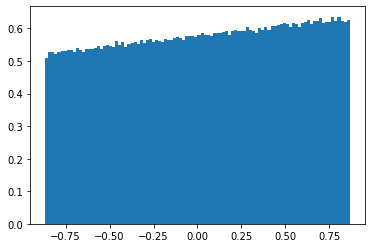

In [9]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
st = generate_linear_distr(s, slope, 1000000)
count, bins, ignored = plt.hist(st, 100, density=True)
plt.show()

Ошибочка вышла

In [13]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions(s, slope, num_conditions * problem.num_objects)
ans = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans.append(problem.run())

100%|██████████| 100/100 [16:37<00:00,  9.97s/it]


In [41]:
time_interval = 15
f_array = []
for i in range(num_conditions):
    M_x = ans[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem.interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 

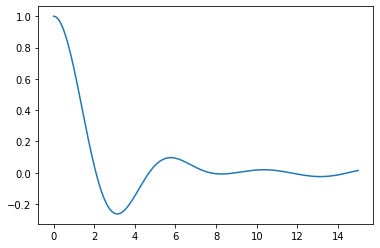

In [43]:
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
plt.plot(t, F)

In [176]:
s = np.sqrt(3) / 2
# slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions_random(s, num_conditions * problem.num_objects)
ans_pr_1 = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_1.append(problem.run())

100%|██████████| 100/100 [16:43<00:00, 10.04s/it]


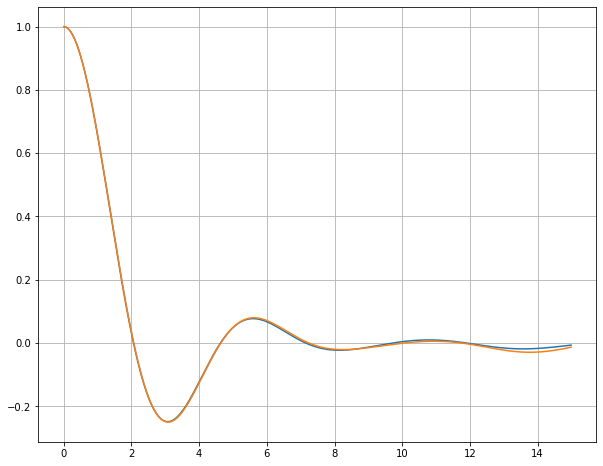

In [177]:
time_interval = 15
problem_interval = 150
f_array = []
num_conditions = 100
problem.discretization = 0.01
for i in range(num_conditions):
    M_x = ans_pr_1[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem_interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
fig = plt.figure(figsize=(10,8))
plt.plot(t, F)

half_conditions = int(num_conditions / 2)
half_aver_f = np.array(f_array[:half_conditions]).sum(axis=0) / half_conditions
half_F = half_aver_f / half_aver_f[0]
plt.plot(t, half_F)
plt.grid()

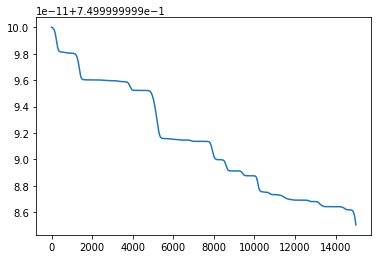

In [166]:
plt.plot(ans[0][0][:, 0] ** 2 + ans[0][0][:, 1] ** 2 + ans[0][0][:, 2] ** 2 )

In [167]:
s = np.sqrt(3) / 2
# slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 1.
problem.J_ort = 0.
problem.discretization = 0.01
problem.interval = 150
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions_random(s, num_conditions * problem.num_objects)
ans_pr_1_add = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_1_add.append(problem.run())

100%|██████████| 100/100 [21:40<00:00, 13.00s/it]


# Ising + analytical

<ipython-input-172-461d6289d45f>:23: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t,(np.sin(t) / t) ** 2, color='purple')


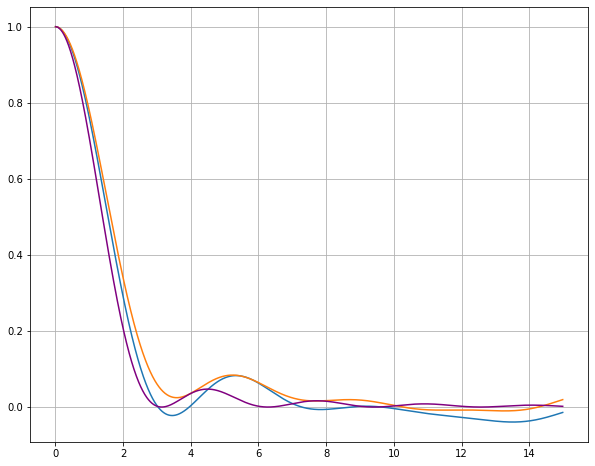

In [172]:
time_interval = 15
problem_interval = 150
f_array = []
num_conditions = 100
problem.discretization = 0.01
for i in range(num_conditions):
    M_x = ans_pr_1_add[i].sum(axis=0)[:, 0]
    f = np.array([0 for _ in range(int(time_interval / problem.discretization))])
    sum_border = int((problem_interval - time_interval) / problem.discretization)
    for n in range(int(time_interval / problem.discretization)):
        f[n] = M_x[:sum_border] @ M_x[n:sum_border + n] / problem.discretization
    f_array.append(f) 
aver_f = np.array(f_array).sum(axis=0) / num_conditions
F = aver_f / aver_f[0]
t = [i * problem.discretization for i in range(len(F))]
fig = plt.figure(figsize=(10,8))
plt.plot(t, F)

half_conditions = int(num_conditions / 2)
half_aver_f = np.array(f_array[:half_conditions]).sum(axis=0) / half_conditions
half_F = half_aver_f / half_aver_f[0]
plt.plot(t, half_F)
plt.plot(t,(np.sin(t) / t) ** 2, color='purple')
plt.grid()

In [173]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 10000

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.01
problem.interval = 15
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z = generate_initial_conditions(s, slope, num_conditions * problem.num_objects)
ans_pr_2_add = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_2_add.append(problem.run())

100%|██████████| 10000/10000 [2:57:27<00:00,  1.06s/it] 


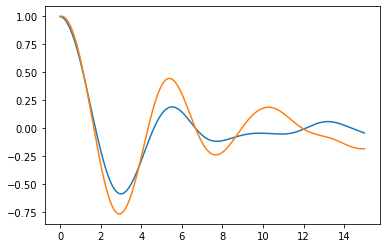

In [97]:
aver_M = 0
for i in range(num_conditions):
    M_x = ans_pr_2[i].sum(axis=0)[:, 0]
    aver_M += M_x / num_conditions
    
F_2 = aver_M / aver_M[0]
t = [i * problem.discretization for i in range(len(F_2))]
plt.plot(t, F_2)

aver_M = 0
half_conditions = int(num_conditions / 2)
for i in range(half_conditions):
    M_x = ans_pr_2[i].sum(axis=0)[:, 0]
    aver_M += M_x / half_conditions
    
half_F_2 = aver_M / aver_M[0]
t = [i * problem.discretization for i in range(len(half_F_2))]
plt.plot(t, half_F_2)


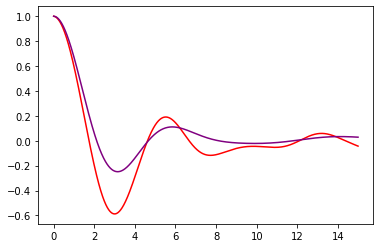

In [104]:
plt.plot(t, F_2, color='r')
plt.plot(t, F, color='purple')

# 10000 samples + comparison

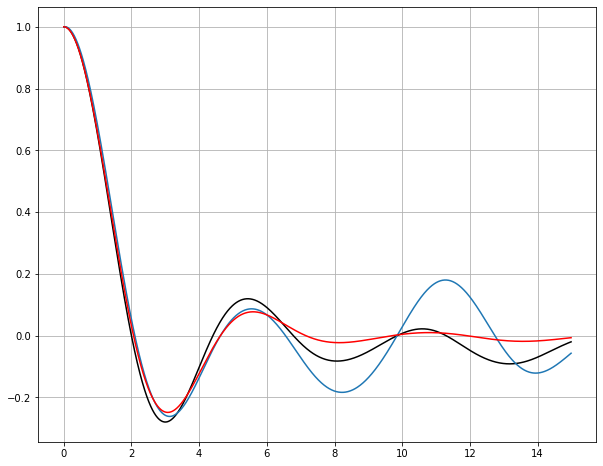

In [184]:
aver_M_add = 0
num_conditions = 10000
for i in range(num_conditions):
    M_x_add = ans_pr_2_add[i].sum(axis=0)[:, 0]
    aver_M_add += M_x_add / num_conditions

    
F_2 = aver_M_add / aver_M_add[0]
t = [i * problem.discretization for i in range(len(F_2))]
fig = plt.figure(figsize=(10,8))
plt.grid()
plt.plot(t, F_2, color='k')

aver_M_add = 0
half_conditions = int(num_conditions / 2)
for i in range(half_conditions):
    M_x = ans_pr_2_add[i].sum(axis=0)[:, 0]
    aver_M_add += M_x / half_conditions
    
half_F_2 = aver_M_add / aver_M_add[0]
t = [i * problem.discretization for i in range(len(half_F_2))]
plt.plot(t, half_F_2)
plt.plot(t, F, color='r')


In [151]:
s = np.sqrt(3) / 2
slope = 1 / s / 20
num_conditions = 100

problem = Shredinger_chain_spins()
problem.num_objects = 11
problem.J_z = 0.82
problem.J_ort = -0.41
problem.discretization = 0.005
problem.interval = 20
problem.is_function_depends_on_x = True
s_0_x, s_0_y, s_0_z, s_0_x_p, s_0_y_p, s_0_z_p = generate_initial_conditions_random_with_perturbation(s, num_conditions * problem.num_objects)
ans_pr_3 = []
ans_pr_3_p = []
for state in tqdm(range(num_conditions)):
    problem.initial_y = np.array([[s_0_x[state * problem.num_objects + n], 
                                   s_0_y[state * problem.num_objects + n],
                                   s_0_z[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_3.append(problem.run())
    problem.initial_y = np.array([[s_0_x_p[state * problem.num_objects + n], 
                                   s_0_y_p[state * problem.num_objects + n],
                                   s_0_z_p[state * problem.num_objects + n]]
                                  for n in range(problem.num_objects)])
    ans_pr_3_p.append(problem.run())

100%|██████████| 100/100 [08:49<00:00,  5.30s/it]


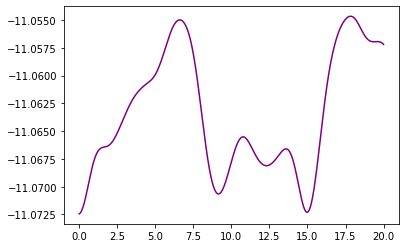

In [158]:
aver_ln_D = 0
t = [i * problem.discretization for i in range(4000)]
num_conditions = 100
for i in range(num_conditions):
    D_i = np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))
    aver_ln_D += np.log(np.sqrt(((ans_pr_3[i] - ans_pr_3_p[i]) ** 2).sum(axis=0).sum(axis=1))) / num_conditions
#     plt.plot(t, D_i)
plt.plot(t, aver_ln_D, color='purple')

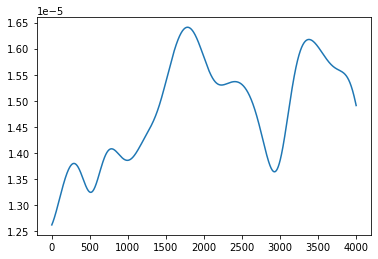

In [156]:
plt.plot(D_i)